In [296]:
%pip install tensorflow

In [218]:
# Importing necessary libraries
import numpy as np
from numpy import concatenate
import pandas as pd
from pandas import read_csv, concat, DataFrame
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set the Seaborn context to 'talk' and style to 'whitegrid'
sns.set_context('talk')
sns.set_style('white')


In [265]:
# Read Excel file
excel_file = 'data/mlfdata.xlsx'
df = pd.read_excel(excel_file, engine='openpyxl')

In [275]:
# Save the data to a CSV file
csv_file = 'data/mlfdata.csv'
df.to_csv(csv_file, index=False)

In [276]:
dataset = read_csv('data/mlfdata.csv')
print(dataset.head())

    state  year     month  tempmax  tempmin  temp  humidity  precip  \
0  Bauchi  2018   January     27.9     11.9  19.8      27.9     0.0   
1  Bauchi  2018  February     34.7     18.1  26.5      28.2     0.0   
2  Bauchi  2018     March     36.5     19.4  28.3      21.5     0.0   
3  Bauchi  2018     April     37.0     23.6  30.2      40.3     0.1   
4  Bauchi  2018       May     34.3     23.8  28.6      63.1     1.7   

   precipcover  cases  
0          0.0      0  
1          1.0      3  
2          0.0      5  
3          1.4      1  
4         11.3      0  


File saved successfully as 'cases_by_years.png'


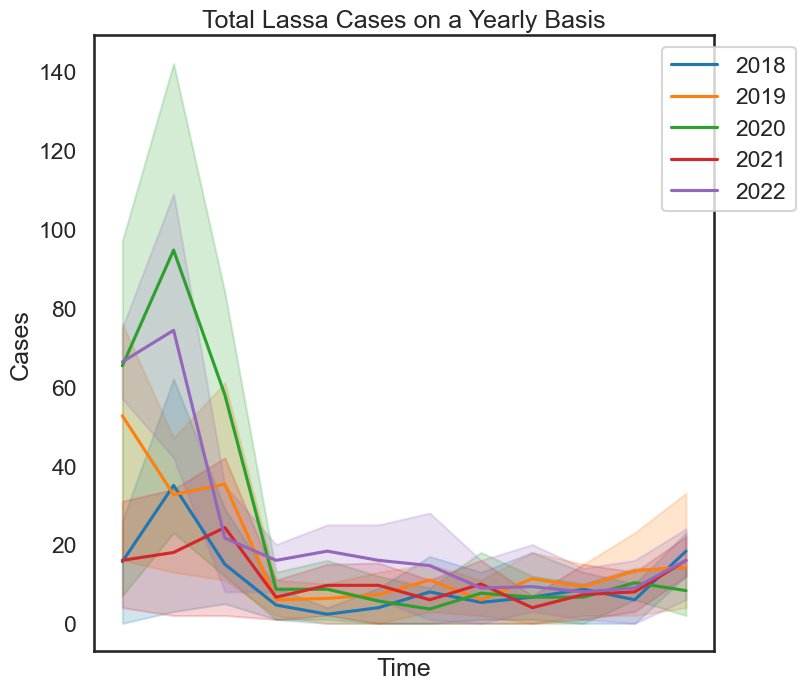

In [277]:
# Distribution of cases in each year
fig, ax = plt.subplots(figsize=(8, 8))

years = np.arange(2018, 2023, 1).astype(int)
for year in years:
    sns.lineplot(data=dataset[dataset.year == year],
                    x="month", y='cases', ax=ax, label=year)
    ax.get_xaxis().set_ticks([])
    ax.set_xlabel('Time')
    ax.set_ylabel('Cases')
    ax.set_title('Total Lassa Cases on a Yearly Basis')
fig.patch.set_alpha(0)
plt.legend(bbox_to_anchor=(1.15, 1), loc="upper right")
fig.savefig('cases_by_years.png', dpi=300)
print("File saved successfully as 'cases_by_years.png'")

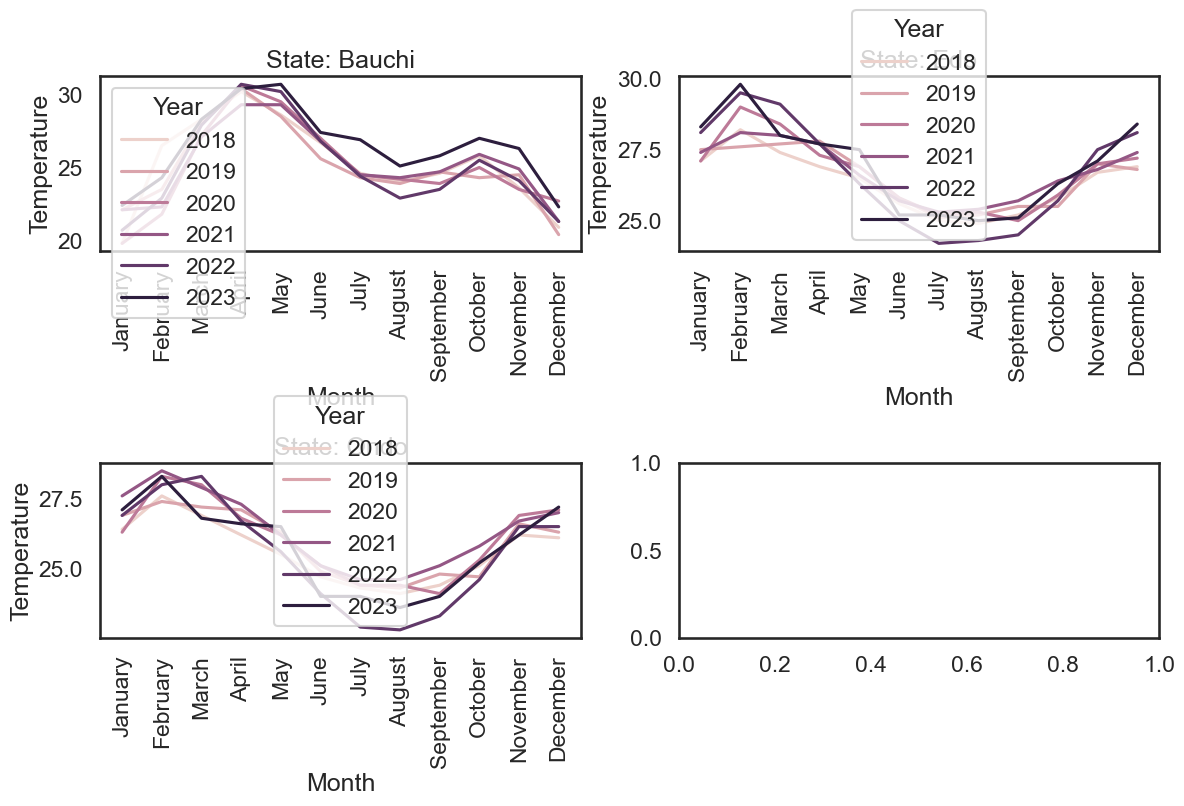

In [278]:
# Assuming df contains the data with columns: 'State', 'Year', 'Month', and numeric features

# Define the figure and axes for plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the data for each state
for i, state in enumerate(dataset['state'].unique()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    state_data = dataset[dataset['state'] == state]
    sns.lineplot(data=state_data, x='month', y='temp', hue='year', ax=ax)
    ax.set_title(f'State: {state}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature')
    ax.legend(title='Year')
    ax.tick_params(axis='x', labelrotation=90)  # Rotate x-axis labels vertically

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [279]:
# Assuming 'month' names are in English and full, e.g., 'January', 'February', etc.
def convert_to_datetime(row):
    # Combine 'year' and 'month' to a date string and parse it
    date_str = f"{row['year']} {row['month']}"
    return pd.to_datetime(date_str, format='%Y %B', errors='coerce')

# Apply this function to each row
dataset['date'] = dataset.apply(convert_to_datetime, axis=1)

In [280]:
# Now set this 'date' column as the index if needed
dataset.set_index('date', inplace=True)

In [281]:
dataset.drop(['year', 'month','state'], axis=1, inplace=True)

In [282]:
print(dataset.head())

            tempmax  tempmin  temp  humidity  precip  precipcover  cases
date                                                                    
2018-01-01     27.9     11.9  19.8      27.9     0.0          0.0      0
2018-02-01     34.7     18.1  26.5      28.2     0.0          1.0      3
2018-03-01     36.5     19.4  28.3      21.5     0.0          0.0      5
2018-04-01     37.0     23.6  30.2      40.3     0.1          1.4      1
2018-05-01     34.3     23.8  28.6      63.1     1.7         11.3      0


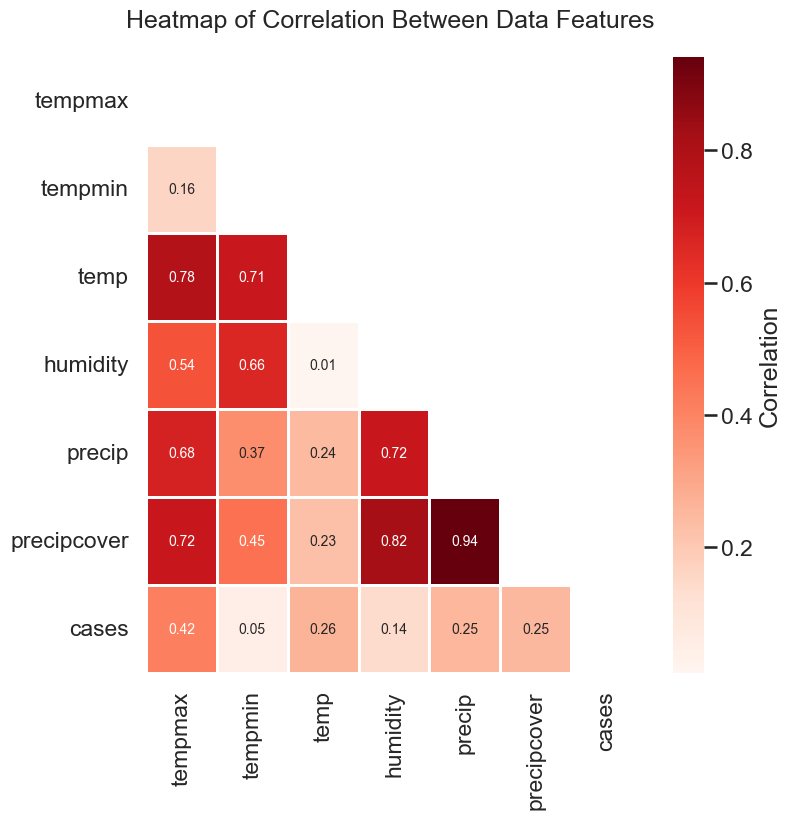

In [284]:
# Heat Map showing the correlation between all variables including the target
corr=dataset.corr().abs()
fig, ax = plt.subplots(figsize=(8,8))
matrix = np.triu(corr) # Getting the lower traingle of the correlation matrix
cbar_kws={"label": "Correlation", "shrink":1}
heatmap=sns.heatmap(data=corr, linewidths=1, square=False, cmap='Reds', ax=ax, annot=True,annot_kws={"size": 10}, mask=matrix, fmt= ".2f",cbar_kws=cbar_kws)
fig.suptitle('Heatmap of Correlation Between Data Features', fontsize=18, y=.94, x=.43);



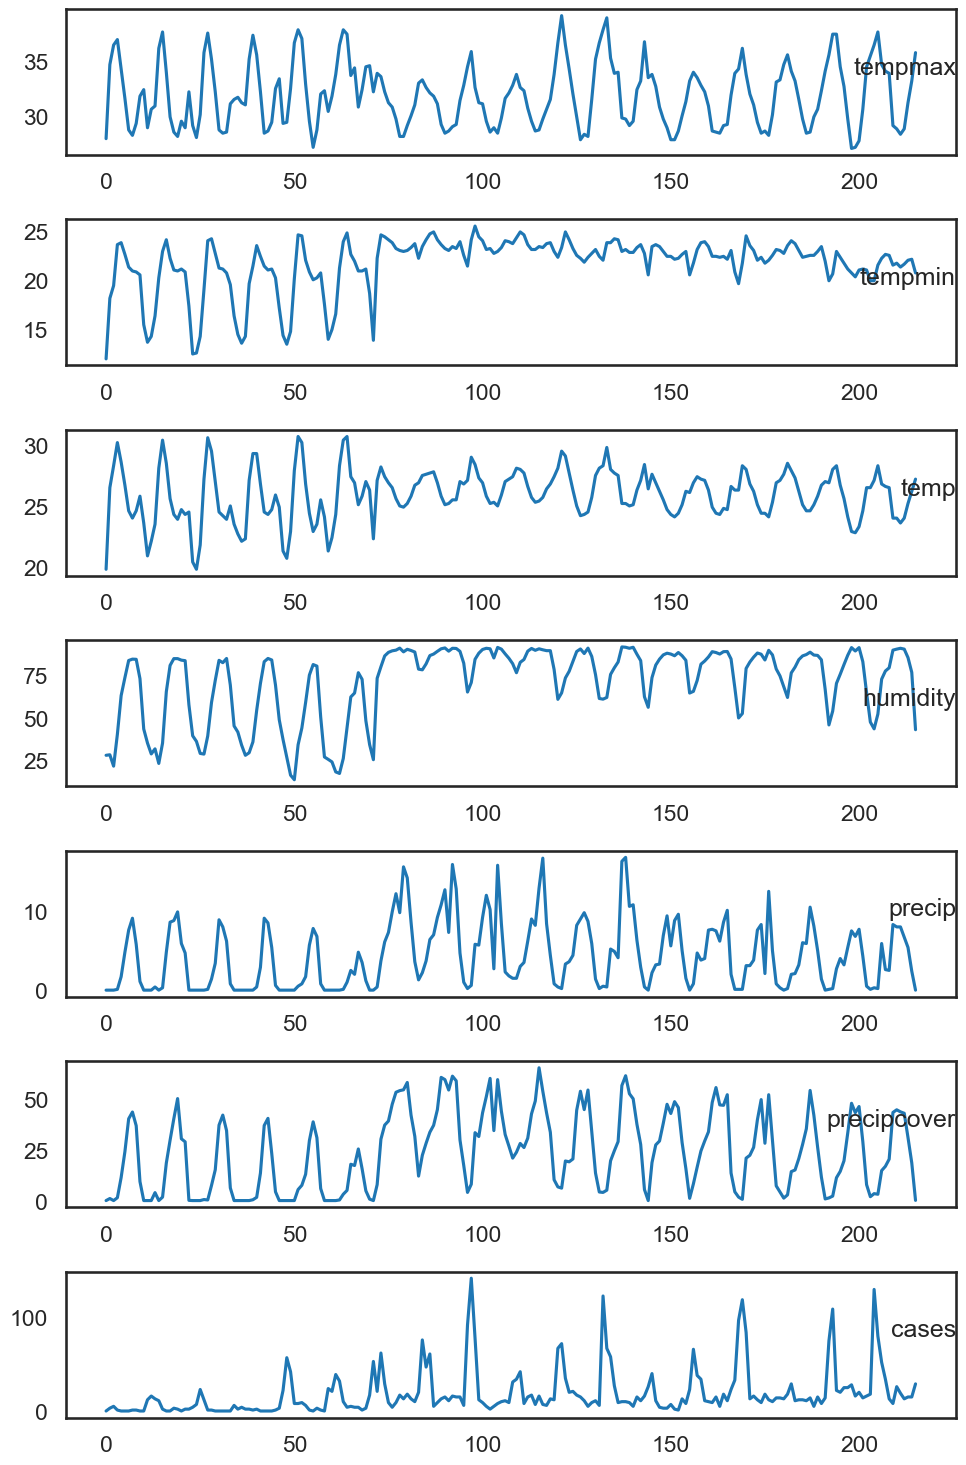

In [285]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(10,15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.tight_layout()
plt.show()

In [286]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    
    Arguments:
        data: Sequence of observations as a list or Pandas DataFrame.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(str(df.columns[j]) + '(t-%d)' % i) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n_out-1)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(str(df.columns[j]) + '(t)') for j in range(n_vars)]
        else:
            names += [(str(df.columns[j]) + '(t+%d)' % i) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [287]:
# Prepare data for LSTM
values = dataset.values
encoder = LabelEncoder()
values[:, 6] = encoder.fit_transform(values[:, 6])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

     0(t-1)    1(t-1)    2(t-1)    3(t-1)    4(t-1)    5(t-1)    6(t-1)  \
1  0.073771  0.000000  0.000000  0.183908  0.000000  0.000000  0.000000   
2  0.631148  0.455882  0.614679  0.187739  0.000000  0.015361  0.050000   
3  0.778688  0.551471  0.779816  0.102171  0.000000  0.000000  0.083333   
4  0.819672  0.860294  0.954128  0.342273  0.005952  0.021505  0.016667   
5  0.598361  0.875000  0.807339  0.633461  0.101190  0.173579  0.000000   

       0(t)      1(t)      2(t)      3(t)      4(t)      5(t)      6(t)  
1  0.631148  0.455882  0.614679  0.187739  0.000000  0.015361  0.050000  
2  0.778688  0.551471  0.779816  0.102171  0.000000  0.000000  0.083333  
3  0.819672  0.860294  0.954128  0.342273  0.005952  0.021505  0.016667  
4  0.598361  0.875000  0.807339  0.633461  0.101190  0.173579  0.000000  
5  0.377049  0.786765  0.633027  0.768838  0.285714  0.368664  0.000000  


In [288]:
# Split into train and test sets
values = reframed.values
n_train_months = int(len(values) * 0.8)
train = values[:n_train_months, :]
test = values[n_train_months:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print("Shape of train_X:", train_X.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of test_X:", test_X.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_X: (172, 1, 13)
Shape of train_y: (172,)
Shape of test_X: (43, 1, 13)
Shape of test_y: (43,)


Epoch 1/50


c:\Users\Yaknan\Documents\Academics\Rebekah's Thesis\thesis_code\lstm_venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 - 1s - 170ms/step - loss: 0.1951 - val_loss: 0.2255
Epoch 2/50
8/8 - 0s - 8ms/step - loss: 0.1691 - val_loss: 0.1775
Epoch 3/50
8/8 - 0s - 7ms/step - loss: 0.1728 - val_loss: 0.1636
Epoch 4/50
8/8 - 0s - 8ms/step - loss: 0.1731 - val_loss: 0.1677
Epoch 5/50
8/8 - 0s - 8ms/step - loss: 0.1701 - val_loss: 0.1729
Epoch 6/50
8/8 - 0s - 8ms/step - loss: 0.1675 - val_loss: 0.1702
Epoch 7/50
8/8 - 0s - 8ms/step - loss: 0.1653 - val_loss: 0.1630
Epoch 8/50
8/8 - 0s - 8ms/step - loss: 0.1640 - val_loss: 0.1565
Epoch 9/50
8/8 - 0s - 8ms/step - loss: 0.1626 - val_loss: 0.1522
Epoch 10/50
8/8 - 0s - 8ms/step - loss: 0.1612 - val_loss: 0.1500
Epoch 11/50
8/8 - 0s - 8ms/step - loss: 0.1592 - val_loss: 0.1471
Epoch 12/50
8/8 - 0s - 8ms/step - loss: 0.1572 - val_loss: 0.1445
Epoch 13/50
8/8 - 0s - 8ms/step - loss: 0.1552 - val_loss: 0.1420
Epoch 14/50
8/8 - 0s - 8ms/step - loss: 0.1532 - val_loss: 0.1392
Epoch 15/50
8/8 - 0s - 8ms/step - loss: 0.1511 - val_loss: 0.1370
Epoch 16/50
8/8 - 0s - 8ms/s

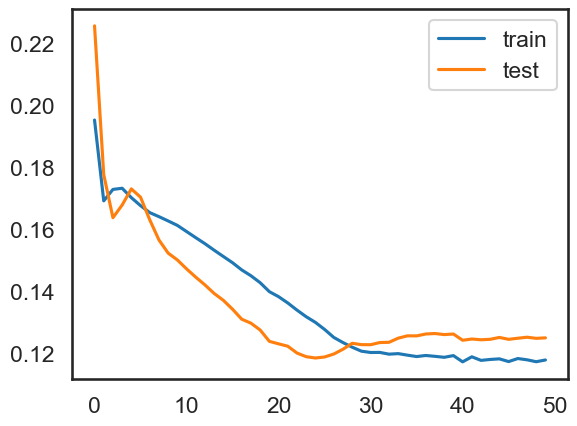

In [295]:
# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=24, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [293]:
# Debugging shapes before prediction
print("Shape of test_X before prediction:", test_X.shape)

# Make a prediction
try:
    yhat = model.predict(test_X)
    print("Shape of yhat:", yhat.shape)
except Exception as e:
    print("Error during prediction:", e)
    print("Input shape to model:", test_X.shape)

# Reshape test_X back to its original shape for inverse scaling
test_X_flat = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Debugging shapes after prediction
print("Shape of yhat:", yhat.shape)
print("Shape of test_X after reshape:", test_X_flat.shape)

# Create an array of zeros to concatenate with yhat for inverse scaling
# Adjusting the shapes to match the scaled data
inv_yhat_full = np.zeros((len(yhat), scaled.shape[1]))
inv_yhat_full[:, 0] = yhat[:, 0]  # Put the predictions in the first column
# Ensure the remaining part of inv_yhat_full matches test_X_flat
inv_yhat_full[:, 1:] = test_X_flat[:, :scaled.shape[1] - 1]  # Adjusting to the correct number of columns

# Invert scaling for forecast
inv_yhat = scaler.inverse_transform(inv_yhat_full)
inv_yhat = inv_yhat[:, 0]

# Invert scaling for actual
test_y_full = np.zeros((len(test_y), scaled.shape[1]))
test_y_full[:, 0] = test_y
# Ensure the remaining part of test_y_full matches test_X_flat
test_y_full[:, 1:] = test_X_flat[:, :scaled.shape[1] - 1]  # Adjusting to the correct number of columns

inv_y = scaler.inverse_transform(test_y_full)
inv_y = inv_y[:, 0]

# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Shape of test_X before prediction: (43, 1, 13)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Shape of yhat: (43, 1)
Shape of yhat: (43, 1)
Shape of test_X after reshape: (43, 13)
Test RMSE: 2.376
